# Workshop sur l’optimisation de portefeuille - Dim 5 nov - 10h

Ce workshop est destiné à vous outiller afin de concevoir le module qui vous permettra de
faire la sélection des titres et le balancement de votre portefeuille.

Les sujets abordés sont: 

- Différentes stratégies (trend following, mean-reversion, ...)
- Modèle de Markowitz: https://www.centralcharts.com/fr/gm/1-apprendre/3-bourse/5-gestion-portefeuille/211-theorie-du-portefeuille-selon-markowitz
- Modèles à facteurs (Fama French)

Pour chaque section, une capsule théorique ainsi que l'application de celle-ci via des librairies python vous serons fournis.

*Le jeu de données utilisé dans ce workhop est identique à celui du défis du datathon*
*Veuillez suivre les guides d'installation fourni pour faire le setup de ce worksop*


In [176]:
#!pip install pandas seaborn matplotlib numpy statsmodels scikit-learn


In [177]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import plotly
import cufflinks
import plotly.express as px

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

## Loading data

In [178]:
ROOT='./kaggle/input/dt23-test/' # remove the dot (.) for the kaggle version

In [179]:
adjusted_close = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close.index = pd.to_datetime(adjusted_close.index)
adjusted_close = adjusted_close.dropna(axis=1).iloc[:,:20]
adjusted_close.head()

adjusted_close.shape

(6022, 20)

## Modèle de Markowitz


### Génération de portefeuilles aléatoires

Nous allons générer des portesfeilles aléatoires conteants les 20 premières actions de notre jeux de donnée. Nous allons assumé avoir l'ensemble des observations pour chacun de ces actifs soit soit le prix de fermeture pour l'ensemble des 6022 jours de données.

Text(0, 0.5, 'Rendement')

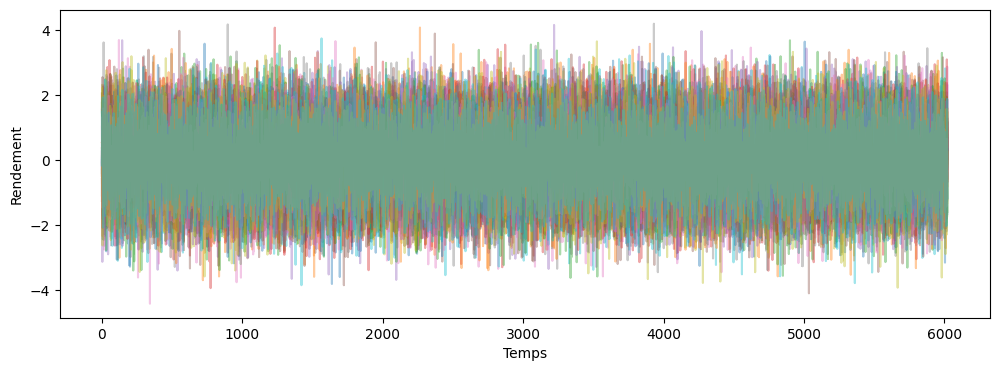

In [180]:
n_assets = len(adjusted_close.columns) # nombre d'actifs désirés dans notre portefeuille
n_obs = len(adjusted_close) # nombre de jours  d'observations par actifs
return_vec = np.random.randn(n_assets, n_obs) 

fig = plt.figure(figsize=(12,4))
plt.plot(return_vec.T, alpha=.4)
plt.xlabel('Temps') 
plt.ylabel('Rendement')

Text(0.5, 1.0, 'Moyenne et écart-type des rendements pour nos portfolios aléatoires')

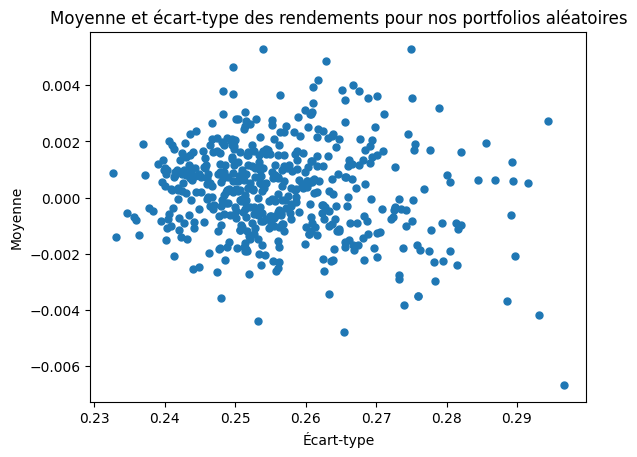

In [181]:
def random_weights(n):
    """
        Retourne une liste de n poids dont la somme donne 1.
    """
    w_i = np.random.rand(n)
    return w_i / sum(w_i)

def random_portfolio(returns):
    """
        Retourne la moyenne et l'écart type du rendement de notre portfolio généré aléatoirement.
    """

    R = np.asmatrix(np.mean(returns, axis=1))
    W = np.asmatrix(random_weights(returns.shape[0]))
    COV = np.asmatrix(np.cov(returns))
    
    µ = W * R.T
    σ = np.sqrt(W * COV * W.T)
    
    if σ > 2:
        return random_portfolio(returns)
    return µ, σ


n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('Écart-type')
plt.ylabel('Moyenne')
plt.title('Moyenne et écart-type des rendements pour nos portfolios aléatoires')


### Création du portefeuille optimale

Maintenant que nous avons vu le retour moyen  de nos portefolios aléatoires, touvons un portefolio optimal soit qui nous donne un meilleur rendement.
Nous cherchons a calculer notre frontière d'efficience en minimisant 

Pour traiter nos matrices, nous utiliserons la librairie CVXOPT (https://cvxopt.org/index.html) :
- blas: https://cvxopt.org/userguide/blas.html
- solvers: https://cvxopt.org/userguide/coneprog.html





In [182]:
def create_markowitz_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 50
    µs = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Création des matrices de contraintes
    
    G = -opt.matrix(np.eye(n))   
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calcul de la frontière d'efficience des weights à l'aide du calcul quadratique
    portfolios = [solvers.qp(µ*S, -pbar, G, h, A, b)['x'] 
                  for µ in µs]
    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    # Calcul du polynôme du 2e degré de la courbe frontière
    m1 = np.polyfit(returns, risks, 2) 
    x1 = np.sqrt(m1[2] / m1[0])

    # Poids du portfolio optimal
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = create_markowitz_portfolio(return_vec)

### Graphe avec frontière efficiente et nuage de points

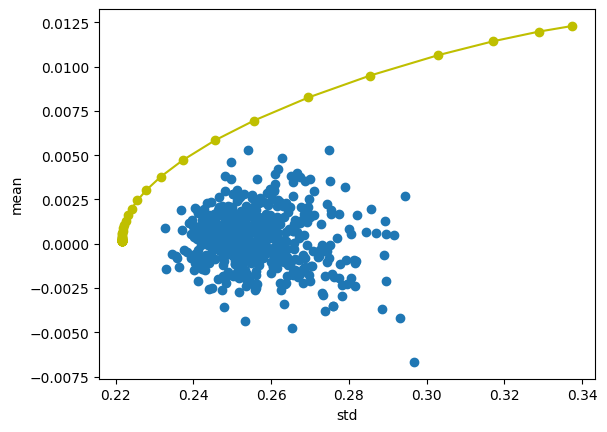

In [196]:
fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

# Modèles à facteurs (Fama French)



## Pondération du portefeuille
Entrez ici les fonctions que vous utiliserez pour générer les poids de votre portefeuille sur base d'indicateurs tirés des données historiques ou produits avec des méthodes statistiques et/ou d'apprentissage machine.

**Assurez vous que la relation $\sum_{i=1}^{i=302}w_i=1$ est toujours respectée.**

Les méthodes que vous voyez ici ne sont pas valides pour la soumission finale:
 - `rand_weights`: sélectionne aléatoirement 5 titres et génère des poids aléatoires.
 - `best_return_fibo`: sélectionne les 10 meilleurs titres en fonction d'une prédiction sur leur rendement et leur assigne des poids proportionnels aux 10 premiers termes de la suite de Fibonacci.

In [184]:
def rand_weights(returns,*args,**kwargs):
    """
        Produces random weights for num_to_select assets 
    """
    weights = np.zeros(len(returns.T))
    num_to_select = 5

    # Generate unique random indices within the array size
    random_indices = np.random.choice(len(weights), num_to_select, replace=False)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[random_indices] = True
    rw = np.random.rand(sum(mask))
    rw /= sum(rw)
    weights[mask]=rw
    return weights

def best_returns_fibo(returns,*args,**kwargs):
    """ 
        Selects the 10 best returns and assigns weights according to a fibonacci ratio 
    """
    weights = np.zeros(len(returns.T))

    # Select the indices of the 10 best stocks
    indices=np.argsort(returns.iloc[-1].values)[::-1][:10]

    # Generate weights according to a fibonacci sequence
    fibo = np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55])[::-1].astype(float)
    fibo /= sum(fibo)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[indices] = True
    
    weights[mask]=fibo
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})


## Modèle prédictif
Programmez ici vos modèles prédictifs et analytiques qui vous permettront de choisir la meilleure pondération possible étant donnée les données antérieures au moment du rebalancement.

C'est ici qu'il faut faire attention à ne pas attraper le *Lukehad Byus*, vous prenez de gros risques si les arguments de vos fonctions prennent en compte des données postérieures au moment du rebalancement ('savoir' à priori qu'AAPL va bien performer constitue une donnée postérieure). 

Le modèle actuel est très simpliste:
- `polynomial_regression`: effectue une simple régression avec un polynome du 3e degré pour essayer de prédire le rendement que fera chaque titre le lendemain.

In [185]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(past_prices):
    """
        Fits a 3d degree polynomial for each asset and returns the predicted value
    """

    models={}

    # Fitting a 3d degree polynomial for each asset
    for c in past_prices.columns:
        x=past_prices[[c]]
        xp = PolynomialFeatures(degree=3).fit_transform(np.arange(len(x)).reshape((len(x),1)))
        model = sm.OLS(x.values, xp).fit()
        models[c] = model

    # Returning the expected return for the next timestep for all stocks
    return pd.DataFrame({k:v.predict(PolynomialFeatures(degree=3).fit_transform(np.array([len(x)]).reshape((1,1)))) for k,v in models.items()})/past_prices.iloc[-1]


## Rebalancement journalier avec Markowitz

Vous choisissez ici ce que vous fournissez aux fonctions précédemment implémentées.

L'utilisation de `rolling()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)) est pratiquement obligatoire pour éviter d'incorporer les données futures dans votre système.

Si vous ne respectez pas l'intervalle `2000-01-01`-`2006-01-01` votre solution ne sera pas acceptée.

In [186]:
weights_df = []
index = []
adjusted_close=adjusted_close.sort_index()
start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2006-01-01')
for x in adjusted_close[(adjusted_close.index>=pd.to_datetime(start))&(adjusted_close.index<pd.to_datetime(stop))].rolling(30):
    if len(x)==30:
        index.append(x.index.max())
        weights_df.append(best_returns_fibo(polynomial_regression(x)))


Génération de la soumission avec le format requis.

In [187]:
weights_df = pd.DataFrame(weights_df,index=index)
weights_df.to_csv('sample_submission.csv')
weights_df

,weight_CSCO,weight_DVN,weight_MRO,weight_BA,weight_GILD,weight_MDT,weight_MO,weight_CTRA,weight_MCHP,weight_EIX,weight_BBY,weight_GEN,weight_WBA,weight_DTE,weight_C,weight_T,weight_APH,weight_SYY,weight_MSI,weight_ADM
2000-02-14,0.384615,0.000000,0.000000,0.000000,0.237762,0.146853,0.090909,0.000000,0.055944,0.0,0.034965,0.020979,0.013986,0.000000,0.000000,0.000000,0.000000,0.006993,0.006993,0.000000
2000-02-15,0.384615,0.000000,0.000000,0.000000,0.237762,0.146853,0.000000,0.000000,0.090909,0.0,0.055944,0.034965,0.020979,0.000000,0.000000,0.000000,0.013986,0.006993,0.006993,0.000000
2000-02-16,0.384615,0.000000,0.000000,0.000000,0.237762,0.146853,0.000000,0.000000,0.090909,0.0,0.055944,0.034965,0.020979,0.000000,0.000000,0.000000,0.013986,0.006993,0.006993,0.000000
2000-02-17,0.384615,0.237762,0.000000,0.000000,0.146853,0.000000,0.000000,0.000000,0.090909,0.0,0.055944,0.034965,0.020979,0.000000,0.000000,0.000000,0.013986,0.006993,0.006993,0.000000
2000-02-18,0.384615,0.237762,0.146853,0.000000,0.090909,0.000000,0.000000,0.000000,0.055944,0.0,0.000000,0.034965,0.020979,0.000000,0.000000,0.000000,0.013986,0.006993,0.000000,0.006993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-23,0.000000,0.000000,0.000000,0.384615,0.237762,0.146853,0.090909,0.055944,0.000000,0.0,0.000000,0.000000,0.034965,0.020979,0.013986,0.000000,0.000000,0.006993,0.000000,0.006993
2005-12-27,0.000000,0.000000,0.384615,0.237762,0.146853,0.090909,0.055944,0.034965,0.000000,0.0,0.000000,0.000000,0.000000,0.020979,0.013986,0.000000,0.000000,0.000000,0.006993,0.006993
2005-12-28,0.000000,0.000000,0.000000,0.384615,0.237762,0.146853,0.090909,0.000000,0.000000,0.0,0.000000,0.000000,0.055944,0.034965,0.020979,0.000000,0.000000,0.013986,0.006993,0.006993
2005-12-29,0.000000,0.000000,0.000000,0.000000,0.384615,0.237762,0.146853,0.000000,0.090909,0.0,0.055944,0.000000,0.000000,0.034965,0.020979,0.013986,0.000000,0.006993,0.006993,0.000000


## Evaluation

In [188]:
prices_df = adjusted_close.loc[weights_df.index]
returns_df = prices_df.shift(-1)/prices_df


In [189]:
bmrk = pd.read_csv(ROOT+'series/benchmark/SPY_returns.csv',index_col=0)
bmrk.index = pd.to_datetime(bmrk.index)


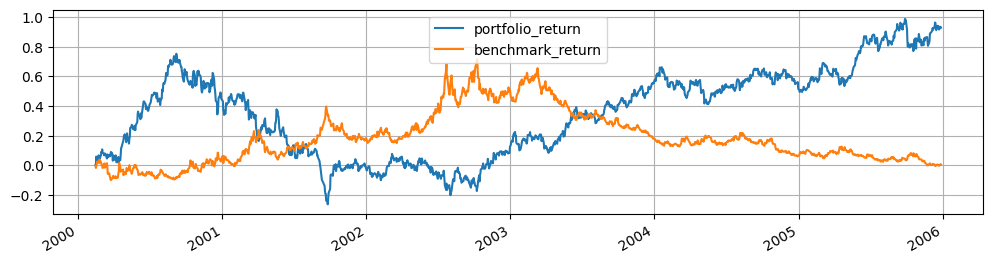

In [190]:
porfolio_performance = pd.DataFrame(pd.DataFrame(returns_df.values*weights_df.values, columns=weights_df.columns, index=weights_df.index).sum(axis=1),columns=['portfolio_return'])[:-2]
daily_returns = porfolio_performance.merge(bmrk,left_index=True,right_index=True,how='left')-1
cumulative_returns = ((daily_returns+1).cumprod()-1)
cumulative_returns.plot(figsize=(12,3))
plt.grid()


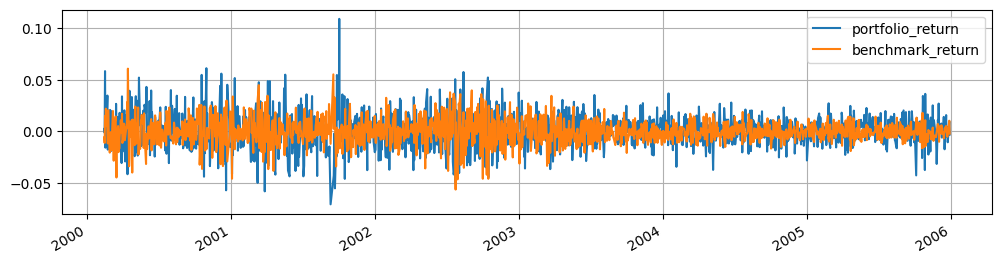

In [191]:
daily_returns.plot(figsize=(12,3))
plt.grid()


In [192]:
cov_matrix = daily_returns.cov()
beta = cov_matrix['portfolio_return']['benchmark_return']/cov_matrix['benchmark_return']['benchmark_return']
beta


-0.005192299107921514

In [193]:
us10bond = pd.read_csv(ROOT+'series/additional_data/us_10ybond_yield.csv',index_col=0)
us10bond.index = pd.to_datetime(us10bond.index)

usCPI = pd.read_csv(ROOT+'series/additional_data/us_CPI.csv',index_col=0)
usCPI.index = pd.to_datetime(usCPI.index)

cpi_idx = lambda x:usCPI[usCPI.index<=pd.to_datetime(x)].index.max()
cumulative_inflation = lambda a,b:(usCPI.loc[cpi_idx(b)]['CPI']-usCPI.loc[cpi_idx(a)]['CPI'])/usCPI.loc[cpi_idx(a)]['CPI']

# risk free rate = 10y bond yield/inflation
rf = ((1+us10bond[us10bond.index<=start].sort_index()['Yield'].values[-1])/100)/cumulative_inflation(start,stop) - 1

# returns
r = cumulative_returns['portfolio_return'].values[-1]
rm = cumulative_returns['benchmark_return'].values[-1]

alpha = r-rf-beta*(rm-rf)
alpha


1.50652345995838

In [194]:
rf,r,rm,alpha,beta


(-0.574566782935191,
 0.9289407677947825,
 0.006275954688565788,
 1.50652345995838,
 -0.005192299107921514)

Return over Max Drawdown

In [195]:
# https://www.investopedia.com/terms/r/return-over-maximum-drawdown-romad.asp
max_draw_down = ((cumulative_returns.cummax()-cumulative_returns)).max()
c_return = cumulative_returns.iloc[-1]
c_return/max_draw_down

portfolio_return    0.915067
benchmark_return    0.008708
dtype: float64